<a href="https://colab.research.google.com/github/nickwan/nwds-stream-notebooks/blob/main/2025_03_29_cuML_nwds.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NVIDIA cuML demo  
Testing out `cuML` with real baseball data. We are taking three seasons-worth of data and training a classifier model to predict pitch type using pitch flight data. We are also training a regressor model to predict the run value of a pitch using the same data we use to predict pitch type (similar to a so-called "stuff" model).  

The total dataset is over 2.3M rows. The feature set is small (10 columns, only 1 categorical) but since it is a lot of rows, random forest training typically takes a long time on Google Colab CPU. Using `cuML` allows us to speed up the training time:  
  
Model | CPU time | `cuML` time | Speed up    
--- | --- | --- | ---   
RF Classifier | 11 mins | 6 sec | >60x   
RF Regressor | 60 mins | 8 sec | >400x  

This was using the Colab Pro instance of the A100. Your results depending on your dataset and GPU availability will vary. I did try this on a smaller, similar dataset using an NVIDIA Tesla P100 card and achieved >60x speed up on a similar classification problem (pitch type classification with the same columns of data, 700K rows instead of 2.3M).   

In [ ]:
# check for GPU instance
!nvidia-smi

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

/bin/bash: line 1: nvidia-smi: command not found


In [ ]:
# this is the cuML one line drop in
%load_ext cuml.accel

<IPython.core.display.Javascript object>

[2025-03-30 02:27:04.514] [CUML] [info] cuML: Installed accelerator for sklearn.
[2025-03-30 02:27:30.128] [CUML] [info] cuML: Installed accelerator for umap.
[2025-03-30 02:27:30.199] [CUML] [info] cuML: Installed accelerator for hdbscan.
[2025-03-30 02:27:30.199] [CUML] [info] cuML: Successfully initialized accelerator.


In [ ]:
# some of this is boiler plate and can be reduced.
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error, log_loss
from scipy.stats import pearsonr, spearmanr
project_dir = 'drive/My Drive/2024-MLB'

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# this is importing 3 seasons of data saved off from Baseball Savant via pybaseball
df = pd.DataFrame()
for fn in os.listdir(project_dir):
  _df = pd.read_csv(f'{project_dir}/{fn}')
  df = pd.concat([df, _df])
df = df.reset_index(drop=True)
df.shape

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

(2301546, 113)

In [ ]:
# some preprocessing
# a variable to detech for left-handed pitchers
# convert pitch names into integer values
# convert game date into a datetime type (for train/test split)
df['is_lhp'] = df['p_throws'].map({'R':0,'L':1})
df['pitch_name_code'] = df['pitch_name'].astype('category').cat.codes
df['game_date'] = pd.to_datetime(df['game_date'])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## RF Classifier

<IPython.core.display.Javascript object>

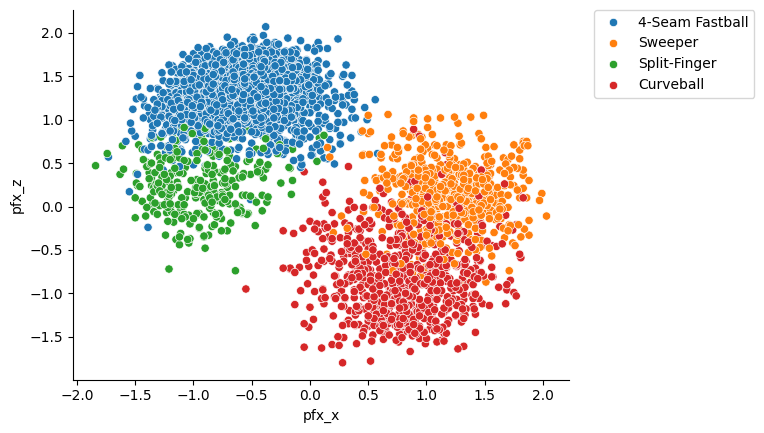

In [ ]:
# an example of pitch types, plotted against pfx_x and pfx_z
sns.scatterplot(data=df.loc[(df['p_throws']=='R') & (df['pitch_type'].isin(['FF','ST','CU','FS']))].sample(5000),
                x='pfx_x', y='pfx_z',
                hue='pitch_name')
sns.despine()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.show()

In [ ]:
# these features are very basic
# all features except for `is_lhp` are straight from the raw data
feats = [
    'pfx_x','pfx_z','release_speed','release_pos_x',
    'release_pos_z','release_extension','arm_angle',
    'is_lhp','release_spin_rate','spin_axis'
]
target = 'pitch_name_code'

# train test split is mimicking having data before july 2024 and predicting
# on data from July 2024 to the end of the MLB season. This is similar to
# some processes where you may need to generate labels for rows overnight
# based off of a previously saved model
train = df.loc[df['game_date']<'2024-07-01'].dropna(subset=feats+[target])
test = df.loc[~df.index.isin(train.index.values)].dropna(subset=feats+[target])

<IPython.core.display.Javascript object>

In [ ]:
train.shape, test.shape

<IPython.core.display.Javascript object>

((1795950, 115), (353550, 115))

In [ ]:
model = RandomForestClassifier()
model.fit(train.loc[:,feats], train[target])
preds = pd.DataFrame(model.predict_proba(test.loc[:,feats]), index=test.index)
test[f'{target}_pred'] = pd.Series(model.predict(test.loc[:,feats]), index=test.index)
loss = log_loss(test[target], preds)
print(loss)

<IPython.core.display.Javascript object>

0.4195677156113473


<IPython.core.display.Javascript object>

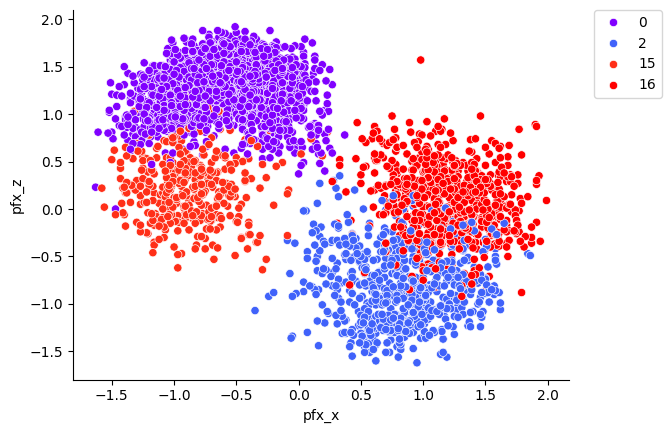

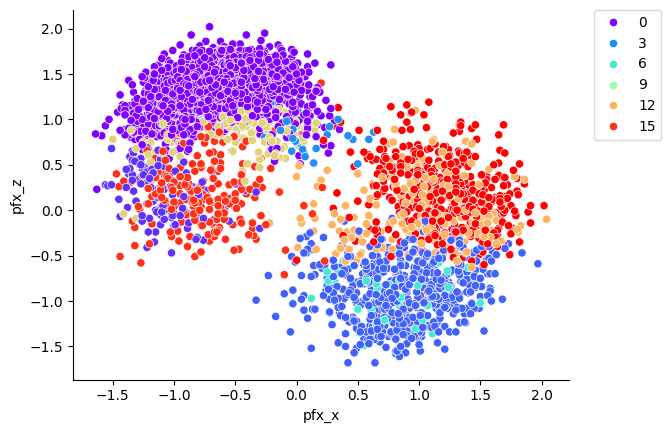

In [ ]:
# this is not necessary for the speed test but if anyone was interested
# in the performance of the model, below is actual (first graph) and
# predicted (second graph). Not great, but tolerable for this example.
sns.scatterplot(data=test.loc[(test['p_throws']=='R') & (test['pitch_type'].isin(['FF','ST','CU','FS']))].sample(5000),
                x='pfx_x', y='pfx_z',
                hue=f'{target}', palette='rainbow')
sns.despine()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.show()

sns.scatterplot(data=test.loc[(test['p_throws']=='R') & (test['pitch_type'].isin(['FF','ST','CU','FS']))].sample(5000),
                x='pfx_x', y='pfx_z',
                hue=f'{target}_pred', palette='rainbow')
sns.despine()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.show()

## RF Regressor

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,delta_run_exp
count,2301380.000
mean,0.000
std,0.227
min,-0.646
25%,-0.061
50%,-0.037
75%,0.039
max,2.701


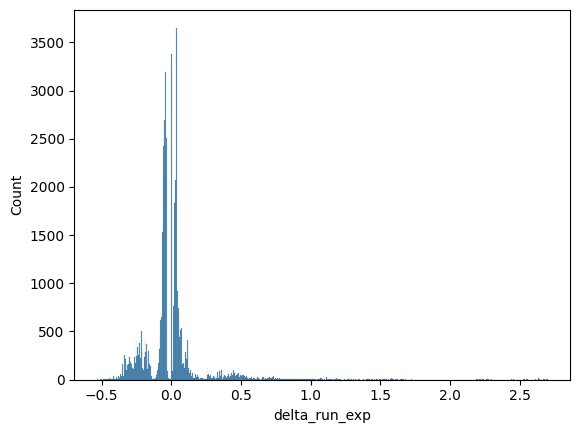

In [ ]:
# instead of predicting pitch type, this model tries to predict
# the run value of a pitch using the `delta_run_exp` column
sns.histplot(df['delta_run_exp'].sample(50000))
df['delta_run_exp'].describe().round(3)

In [ ]:
feats = [
    'pfx_x','pfx_z','release_speed','release_pos_x',
    'release_pos_z','release_extension','arm_angle',
    'is_lhp','release_spin_rate','spin_axis'
]
target = 'delta_run_exp'

train = df.loc[df['game_date']<'2024-07-01'].dropna(subset=feats+[target])
test = df.loc[~df.index.isin(train.index.values)].dropna(subset=feats+[target])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
model = RandomForestRegressor()
model.fit(train.loc[:,feats], train[target])
test[f'{target}_pred'] = pd.Series(model.predict(test.loc[:,feats]), index=test.index)
rmse = mean_squared_error(test[target], test[f'{target}_pred'])**0.5
print(rmse)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

0.22863379121636326


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,delta_run_exp_pred
count,353517.000
mean,0.013
std,0.041
min,-0.154
25%,-0.015
50%,0.008
75%,0.034
max,0.786


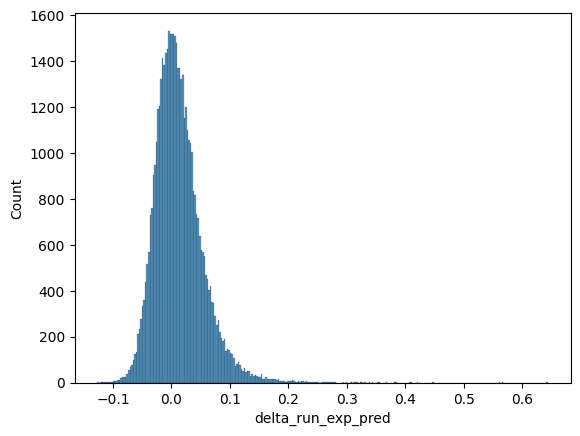

In [ ]:
# again, the results are not necessary for the speed test but
# if you are interested in the performance, you can compare the below
# model results to the true distribution at the top of this section
sns.histplot(test[f'{target}_pred'].sample(50000))
test[f'{target}_pred'].describe().round(3)

# If you liked this notebook
## and are interested in live data science content, check me out on Twitch  
## https://twitch.tv/nickwan_datasci  

nodd jorkin